In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.1.3
tiktoken version: 0.9.0
torch version: 2.7.1
tensorflow version: 2.19.0


In [2]:
import torch
from gpt import GPTModel
GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":256,
    "emb_dim":468,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 468)
  (pos_emb): Embedding(256, 468)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=468, out_features=468, bias=False)
        (W_key): Linear(in_features=468, out_features=468, bias=False)
        (W_value): Linear(in_features=468, out_features=468, bias=False)
        (out_proj): Linear(in_features=468, out_features=468, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=468, out_features=1872, bias=True)
          (1): GELU()
          (2): Linear(in_features=1872, out_features=468, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [4]:
import tiktoken
from gpt import generate_text_simple
def text_to_token_ids(text,tokenizer):
    encoded=tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor=torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor
def token_ids_to_text(token_ids,tokenizer):
    flat=token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [5]:
start_context="Every effort moves you"
tokenizer=tiktoken.get_encoding("gpt2")
token_ids=generate_text_simple(model=model,idx=text_to_token_ids(start_context,tokenizer),max_new_tokens=10,context_size=GPT_CONFIG_124M['context_length'])

In [6]:
print("output text:\n", token_ids_to_text(token_ids,tokenizer))

output text:
 Every effort moves you behaves Nolan contact contributingchair guessesimil YellowArthur university


# Calculating the text generation loss: cross-entropy and perplexity

In [7]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) # "really like chocolate"]

In [8]:
with torch.no_grad():
    logits=model(inputs)
probas=torch.softmax(logits,dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [9]:
token_ids=torch.argmax(probas,dim=-1,keepdim=True)
print(token_ids)

tensor([[[37259],
         [28694],
         [33906]],

        [[36750],
         [43005],
         [13144]]])


In [10]:
print(f"Targets batch 1: {token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  rainy009Va


In [11]:
text_idx=0
target_probas_1=probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 1:",target_probas_1)
text_idx=1
target_probas_2=probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 2:",target_probas_2)

Text 1: tensor([4.9556e-06, 8.7060e-06, 2.5850e-05])
Text 2: tensor([9.7422e-06, 3.1885e-05, 3.1743e-05])


compute logarithm of all token probabilities

In [12]:
log_probas=torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([-12.2150, -11.6515, -10.5632, -11.5390, -10.3534, -10.3578])


calculate the average probabiity for each token

In [13]:
avg_log_probas=torch.mean(log_probas)
print(avg_log_probas)

tensor(-11.1133)


In [14]:
neg_avg_log_probas=avg_log_probas*-1
print(neg_avg_log_probas)

tensor(11.1133)


In [15]:
print("logitsa shape",logits.shape)
print("targets shape",targets.shape)

logitsa shape torch.Size([2, 3, 50257])
targets shape torch.Size([2, 3])


In [16]:
logits_flat=logits.flatten(0,1)
targets_flat=targets.flatten()
print("Flattened logits:",logits_flat.shape)
print("Flattened targets:",targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [17]:
#defining the loss functions
loss=torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(11.1133)


In [18]:
#perplexity of the model
perplexity=torch.exp(loss)
print(perplexity)

tensor(67058.9297)


# Calculating the training and validation set losses

In [19]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [20]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [21]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [22]:
total_characters=len(text_data)
total_tokens=len(tokenizer.encode(text_data))
print("Characters:",total_characters)
print("tokens:",total_tokens)

Characters: 20479
tokens: 5145


In [23]:
from dataloader import create_dataloader_v1

In [24]:
train_ratio=0.90
split_idx=int(train_ratio*len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

In [25]:
torch.manual_seed(123)
train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [26]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [27]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)
print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [28]:
train_tokens=0
for input_batch,target_batch in train_loader:
    train_tokens+=input_batch.numel()
val_tokens=0
for input_batch,target_batch in val_loader:
    val_tokens+=input_batch.numel()
print("Training tokens:",train_tokens)
print("Validation tokens:",val_tokens)
print("All tokens:",train_tokens+val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [29]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch=input_batch.to(device),target_batch.to(device)
    logits=model(input_batch)
    loss=torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [30]:
torch.cuda.is_available()

False

In [31]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [32]:
torch.accelerator.is_available()

False

In [33]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device)
    val_loss=calc_loss_loader(val_loader,model,device)
print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 11.001415040757921
Validation loss: 10.9550199508667


# Training an LLM

In [32]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [34]:
device

device(type='cpu')

In [33]:
#now training the LLM
import time
start_time=time.time()
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)
num_epochs=10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
end_time=time.time()
execution_time_minutes=(end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 10.398, Val loss 10.360
Ep 1 (Step 000005): Train loss 8.895, Val loss 9.058
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

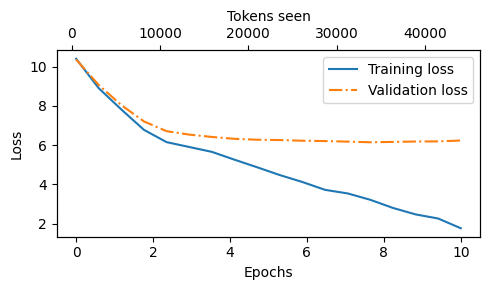

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Decoding strategies to control randomness

In [35]:
model.to("cpu")
model.eval()
tokenizer=tiktoken.get_encoding("gpt2")
token_ids=generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]   
)
print("Output text: \n",token_ids_to_text(token_ids,tokenizer))

Output text: 
 Every effort moves you know," was not that my hostess was "I was a that point I had been of the fact that one of the


torch.save(model.state_dict(), "model.pth")

In [34]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 468)
  (pos_emb): Embedding(256, 468)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=468, out_features=468, bias=False)
        (W_key): Linear(in_features=468, out_features=468, bias=False)
        (W_value): Linear(in_features=468, out_features=468, bias=False)
        (out_proj): Linear(in_features=468, out_features=468, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=468, out_features=1872, bias=True)
          (1): GELU()
          (2): Linear(in_features=1872, out_features=468, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [36]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
"model_and_optimizer.pth")

NameError: name 'optimizer' is not defined

# Temperature Scaling

In [37]:
vocab={
    "closer":0,
    "every":1,
    "effort":2,
    "forward":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8
}

In [38]:
inverse_vocab={v:k for k,v in vocab.items()}

In [39]:
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [44]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [48]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [49]:
torch.manual_seed(123)
next_token_id=torch.multinomial(probas,num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [54]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample=[torch.multinomial(probas,num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i,freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

In [55]:
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


In [59]:
def softmax_with_temperature(logits,temperature):
    scaled_logits=logits/temperature
    return torch.softmax(scaled_logits,dim=0)

In [60]:
temperatures=[1,0.1,5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

In [61]:
import matplotlib.pyplot as plt

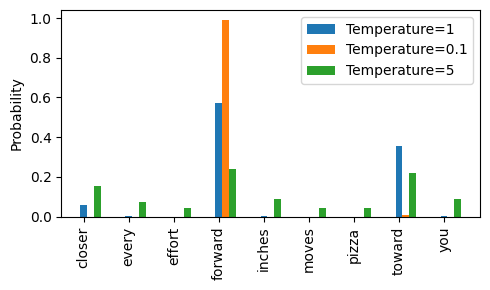

In [62]:
x=torch.arange(len(vocab))
bar_width=0.15
fig,ax=plt.subplots(figsize=(5,3))
for i,T in enumerate(temperatures):
    rects=ax.bar(x+i*bar_width,scaled_probas[i],bar_width,label=f'Temperature={T}')
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig("temperatures-plot.pdf")
plt.show()

In [63]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [64]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


# Top K sampling

In [65]:
top_k=3
top_logits,top_pos=torch.topk(next_token_logits,top_k)
print("top logits:",top_logits)
print("top pos:",top_pos)

top logits: tensor([6.7500, 6.2800, 4.5100])
top pos: tensor([3, 7, 0])


In [68]:
new_logits=torch.where(
    condition=next_token_logits<top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [70]:
topk_probas=torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


# Modifying the text generation function

In [71]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [73]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was not that my own picture his! "I must up-


# Loading pretrained weights from OpenAI

In [74]:
file_name="gpt2-small-124M.pth"

In [75]:
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

In [76]:
if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

Downloaded to gpt2-small-124M.pth


In [79]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

In [80]:
gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

KeyError: 'emb_dim'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

In [ ]:

torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


In [82]:
from gpt_download import download_and_load_gpt2
settings,params=download_and_load_gpt2(model_size="124M",models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 21.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 687kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 34.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [07:29<00:00, 1.11MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.72MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 383kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 452kiB/s]  


In [83]:
print("Settings:",settings)
print("Parameter dictionary keys:",params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [84]:
print(params["wte"])
print("Token ebedding weight tensor dimensions:",params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token ebedding weight tensor dimensions: (50257, 768)


In [85]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [86]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [87]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [88]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


